# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas físicas

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Base de Dados

In [220]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [221]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8,'set': 9, 'out': 10, 'nov': 11, 'dez': 12}
caminho_bases = pathlib.Path('dataset')

base_df = pd.DataFrame()

#Lista de arquivos a serem trabalhos em 'dataset'
for arquivo in caminho_bases.iterdir():
    mes = meses[arquivo.name[0:3]]
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
              
    df = pd.read_csv(caminho_bases / arquivo.name)
    df['mes'] = mes
    df['ano'] = ano
    base_df = base_df.append(df)

display(base_df)

C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (62,87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
34325,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
34326,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
34327,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


- A quantidade de colunas descenessárias para o modelo pode deixar o modelo. Por isso muitas serão deletadas.
- Além disso, para o modelo de previsão muitas coluas não serão necerrária.
- Tipo de colunas que iremos excluir.

    1. ID,s, Links e informações não relevantes para o modelo
    2. Colunas repetidias ou colunas com informações parecidas. Ex Data x Ano/mes
    3. Colunas de texto livre, não rodaremos análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos são iguais.


- Para isso será gerado um arquivo excel com os 1000 primeiros registros para uma análise qualitativa.

In [222]:
print(list(base_df.columns))
base_df.head(1000).to_csv('primeiros_registros.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Despois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:


In [223]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','mes','ano']
base_df = base_df.loc[:, colunas]
print(len(colunas))
display(base_df)


34


,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,mes,ano
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,4,2018
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,4,2018
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,4,2018
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,4,2018
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,4,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,9,2019
34325,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,9,2019
34326,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,9,2019
34327,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,9,2019


### Tratar valores faltantes

- Análisando os dados percebemos que existe grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluídas da análise.
- Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém NaN.

In [224]:
for coluna in base_df:
    if base_df[coluna].isnull().sum() >= 300000:
        base_df = base_df.drop(coluna, axis=1)

base_df = base_df.dropna()
print(base_df.isnull().sum())
print(base_df.shape)

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
mes                         0
ano                         0
dtype: int64
(897709, 23)


### Verificar Tipos de Dados em cada coluna

In [225]:
print(base_df.dtypes)
print('-'*60)

print(base_df.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
mes                           int64
ano                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- Como 'preço' e extra_people' estão sendo reconhecidos como objetivos teremos que alterar o tipo de dados da coluna.

In [226]:
#price - int
base_df['price'] = base_df['price'].str.replace('$','')
base_df['price'] = base_df['price'].str.replace(',','')
base_df['price'] = base_df['price'].astype(np.float32, copy=False)

#extra_people - int
base_df['extra_people'] = base_df['extra_people'].str.replace('$','')
base_df['extra_people'] = base_df['extra_people'].str.replace(',','')
base_df['extra_people'] = base_df['extra_people'].astype(np.float32, copy=False)

#Verificando os tipos
print(base_df.dtypes)

C:\Users\dougl\AppData\Local\Temp/ipykernel_18288/1606411460.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_df['price'] = base_df['price'].str.replace('$','')
C:\Users\dougl\AppData\Local\Temp/ipykernel_18288/1606411460.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_df['extra_people'] = base_df['extra_people'].str.replace('$','')


host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
mes                           int64
ano                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para :
    
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5 x Amplitude(Q3 -Q1) e valores acima de Q3 + 1.5 x Amplitude(Q3 -Q1)
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir.

- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores númericos continuos.
- Depois vamos analisar as colunas de valores númeriso discretos (accomodates, bedrooms, guests_included, etc.)
- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

## Correlação

(897709, 23)


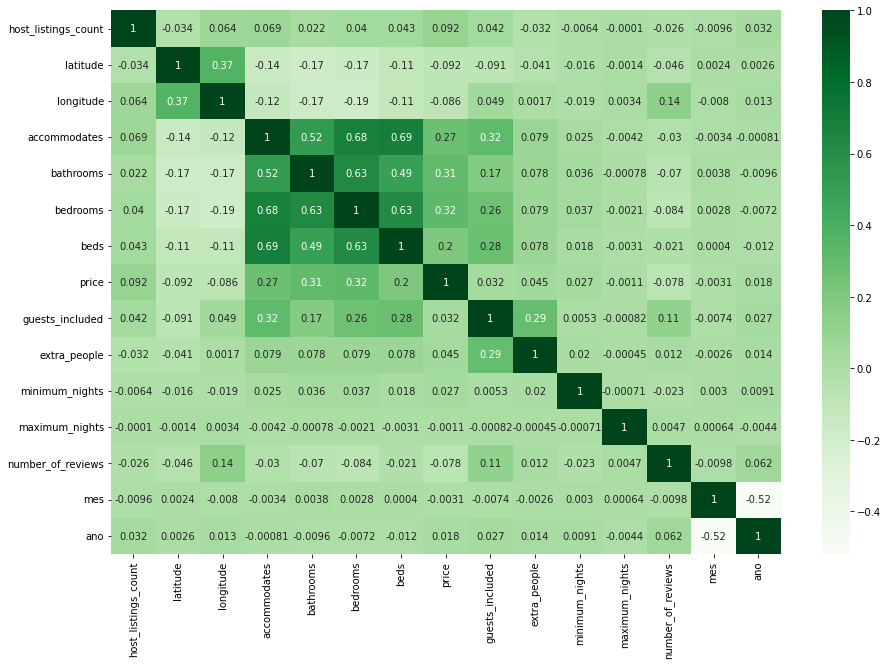

In [227]:
plt.figure(figsize=(15,10))
sns.heatmap(base_df.corr(), annot=True, cmap="Greens")

#print(base_df.corr())
print(base_df.shape)

## Funções Análisando Outliers

- Definindo funções para auxiliar nas análises de outliers.
- Funções para gráficos.
- Funções para limites superior e inferior

##### Fórmula

- Q1 - 1.5 * Amplitude(Q3 - Q1) e valores acima de Q3 + 1.5 * Amplitude(Q3 - Q1)

Quartil 1 é a última posição de 25% da quantidade de valors do total e assim sucessivamente.

- Conceito Quartil de estatística:
- Amplitude é a diferença do primeiro(Q1) quartil pelo terceiro(Q3) quartil.

Q1 25 % |||| Q2 50% |||| Q3 75% |||| Q4 100% ||||

1. Q1 = Valor da posição 25%
2. Q2 = Valor da posição 50%
3. Q3 = Valor da posição 75%
4. Q4 = Valor da posição 100%

In [228]:
#Calculando Outliers Inferior e Superior
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
def excluir_outliers(df, nome_coluna):
    qtd_linhas_atual = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtd_linhas_atual - df.shape[0]
    return df, linhas_removidas 
        
#Plota os dois gráficos um com todos os valores do quartil e o outro com os Outliers definidos
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15,5)
    ax1.set_xlim(coluna.min(), coluna.max())
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
#Gráfico de Linhas
def histograma(coluna):
    plt.figure(figsize=(15,5))
    sns.distplot(coluna, hist=True)

def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### price

C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


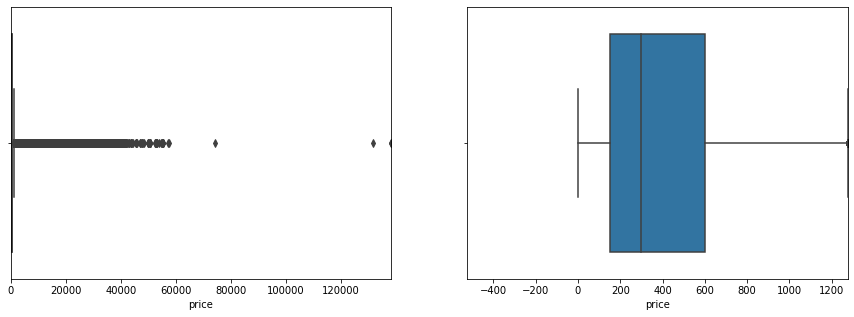

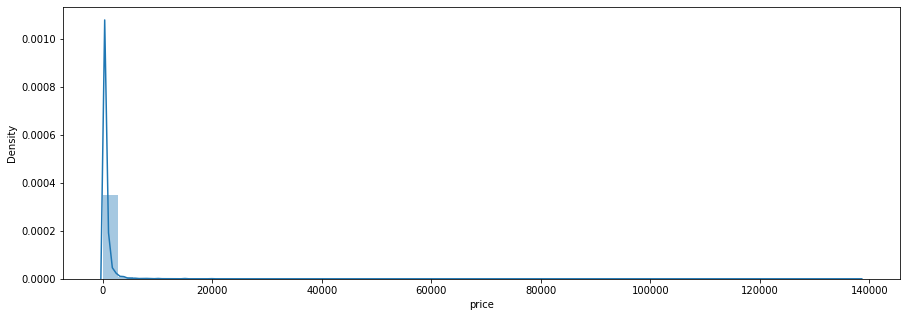

In [229]:
diagrama_caixa(base_df['price'])
histograma(base_df['price'])

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão de apenas de 
apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso podemos excluir esses outliers.

- Interrante a tendência de precificação para valores cheios como 200, 400, 600 e etc.

In [230]:
base_df, linhas_removidas = excluir_outliers(base_df, 'price')
print(f"Foram excluídas {linhas_removidas} linhas.")

Foram excluídas 87282 linhas.


C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(810427, 23)


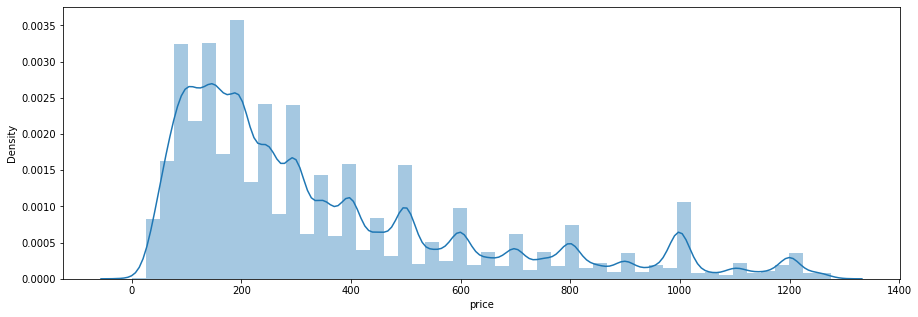

In [231]:
histograma(base_df['price'])
print(base_df.shape)

### extra_people

C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


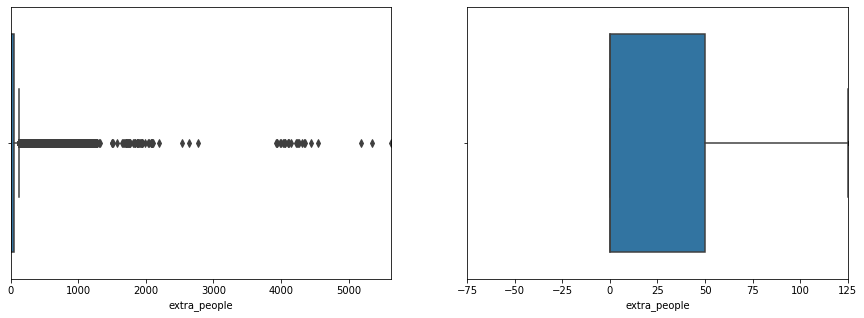

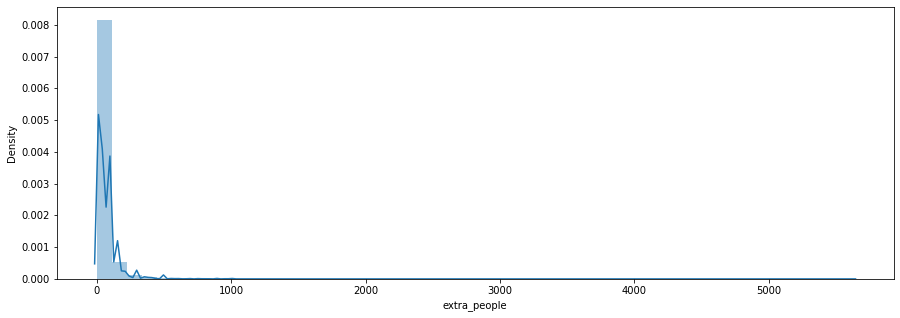

In [232]:
diagrama_caixa(base_df['extra_people'])
histograma(base_df['extra_people'])

In [233]:
base_df, linhas_removidas = excluir_outliers(base_df, 'extra_people')
print(f"Foram excluídas {linhas_removidas} linhas.")

Foram excluídas 59194 linhas.


C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(751233, 23)


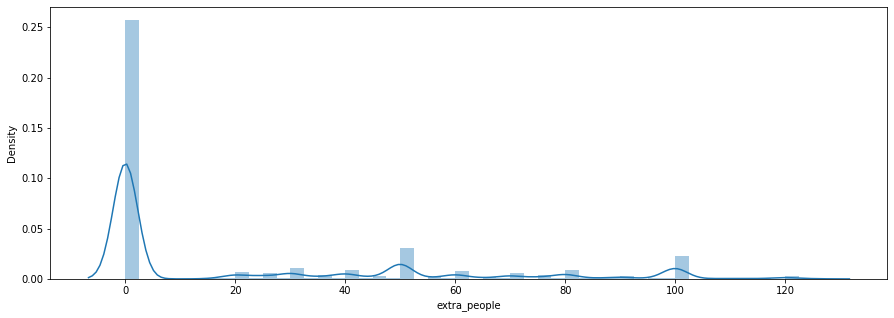

In [234]:
histograma(base_df['extra_people'])
print(base_df.shape)

### host_listings_count                                                

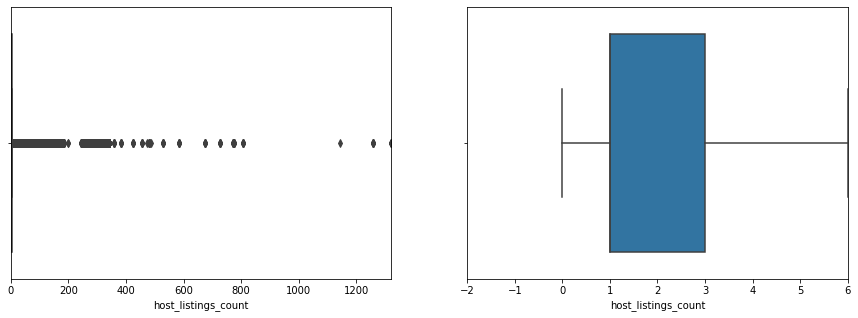

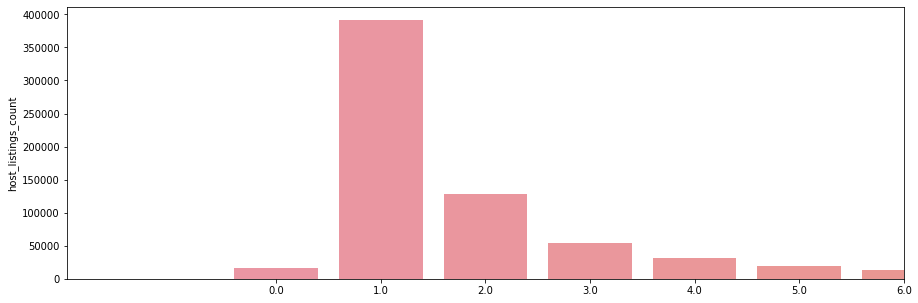

In [235]:
diagrama_caixa(base_df['host_listings_count'])
grafico_barra(base_df['host_listings_count'])

Podemos excluir os Outliers por conta do objetivo do projeto. Hosts com mais de 6 imóveis no AIRBNB não é o público alvo do projeto, podendo ser imobiliárias ou profissionais que gerenciam imóveis. 

Foram excluídas 19717 linhas.


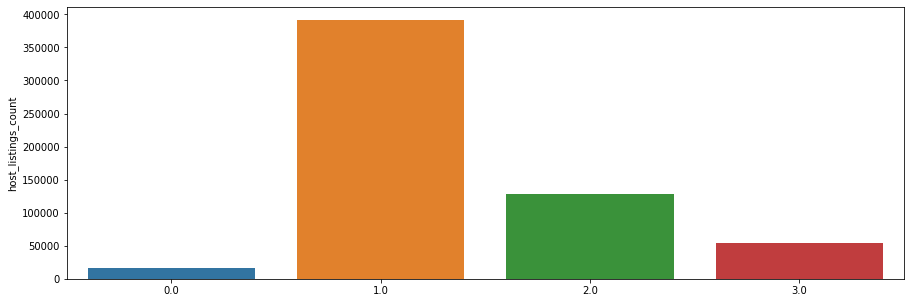

In [236]:
base_df, linhas_removidas = excluir_outliers(base_df, 'host_listings_count')
print(f"Foram excluídas {linhas_removidas} linhas.")
grafico_barra(base_df['host_listings_count'])

### accommodates                  

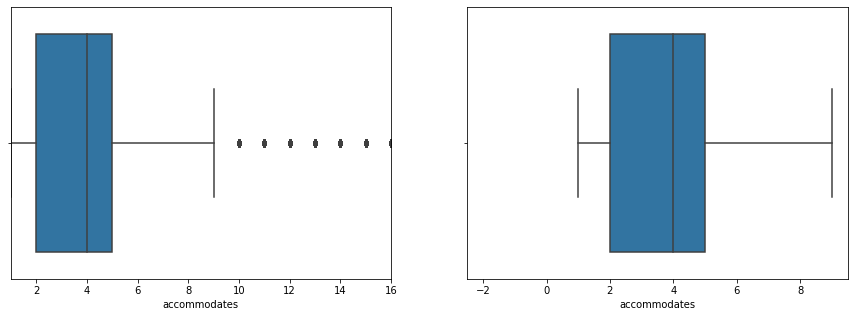

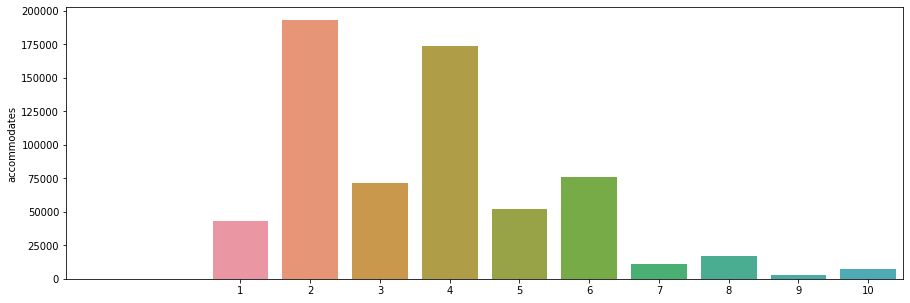

In [237]:
diagrama_caixa(base_df['accommodates'])
grafico_barra(base_df['accommodates'])

In [238]:
base_df, linhas_removidas = excluir_outliers(base_df, 'accommodates')
print(f"Forma escluídas {linhas_removidas} linhas.")

Forma escluídas 21290 linhas.


### bathrooms

<AxesSubplot:ylabel='bathrooms'>

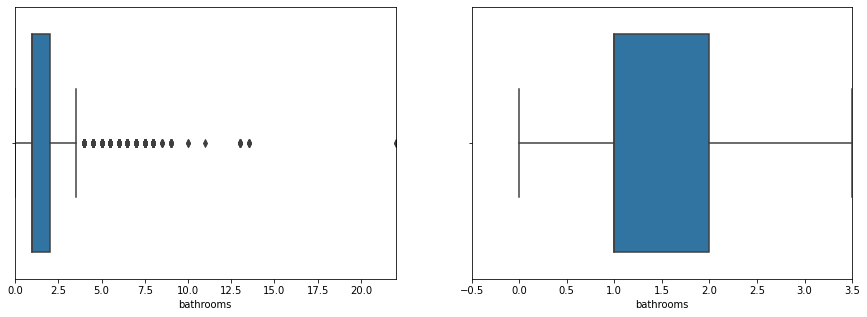

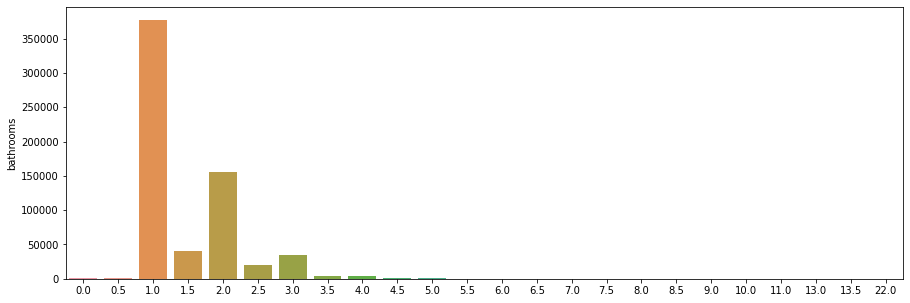

In [239]:
diagrama_caixa(base_df['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x=base_df['bathrooms'].value_counts().index, y=base_df['bathrooms'].value_counts())


Foram excluídas 19717 linhas.


<AxesSubplot:ylabel='bathrooms'>

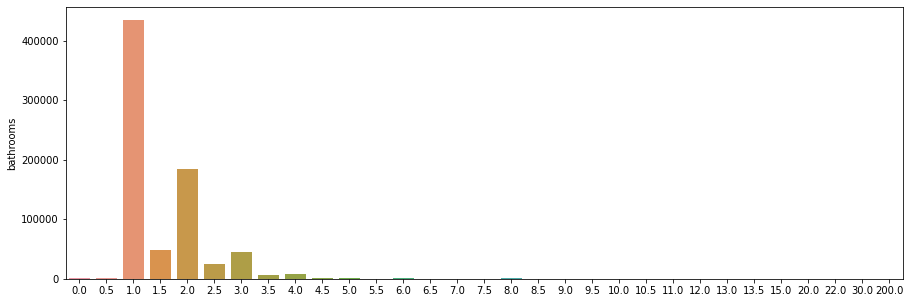

In [240]:
base_df, linhas_removidas = excluir_outliers(base_df, 'bathrooms')
print(f"Foram excluídas {linhas_removidas} linhas.")

### bedrooms

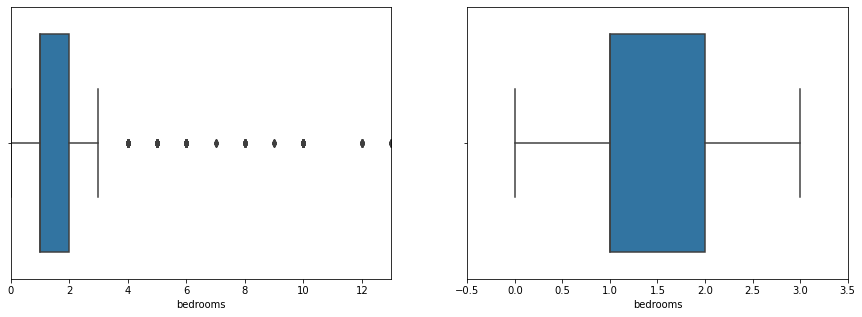

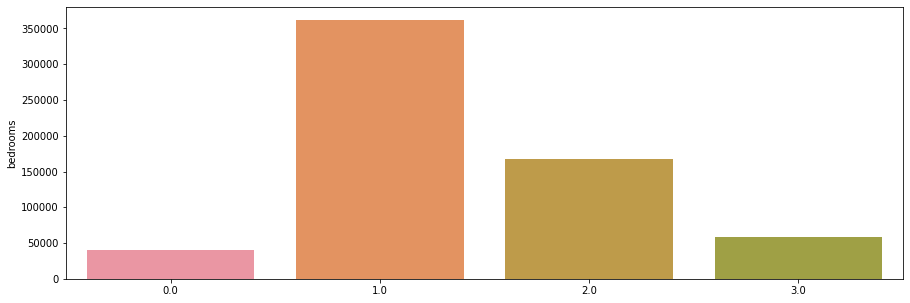

In [241]:
diagrama_caixa(base_df['bedrooms'])
grafico_barra(base_df['bedrooms'])

In [242]:
base_df, linhas_removidas = excluir_outliers(base_df, 'bedrooms')
print(f"Foram excluídas {linhas_removidas} linhas.")

Foram excluídas 5482 linhas.


### beds

(-2.0, 6.0)


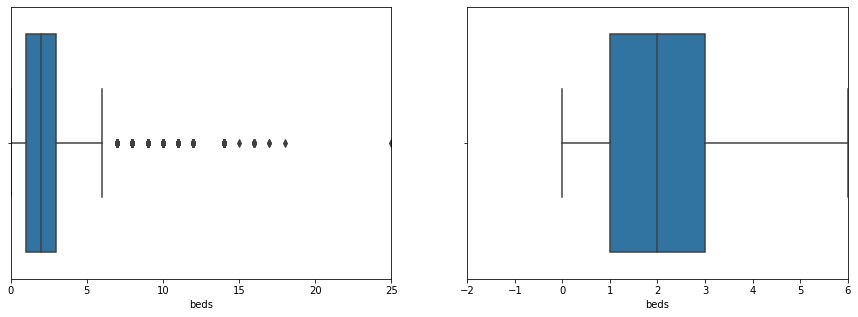

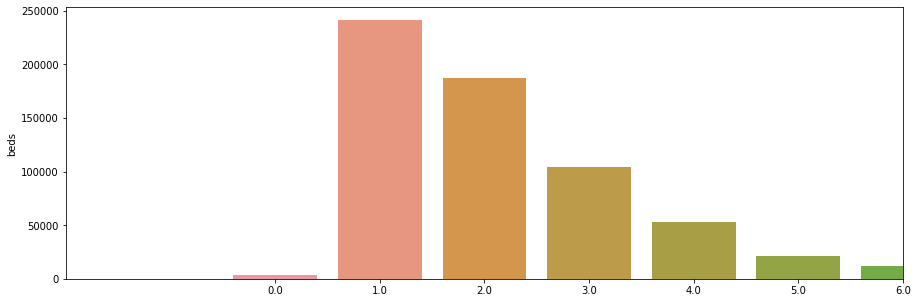

In [243]:
diagrama_caixa(base_df['beds'])
grafico_barra(base_df['beds'])

In [244]:
base_df, linhas_removidas = excluir_outliers(base_df, 'beds')
print(f"Foram excluídas {linhas_removidas} linhas.")

Foram excluídas 5622 linhas.


### guests_included               


(1.0, 1.0)


C:\Users\dougl\AppData\Local\Temp/ipykernel_18288/2507687861.py:20: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\dougl\AppData\Local\Temp/ipykernel_18288/2507687861.py:31: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(limites(coluna))


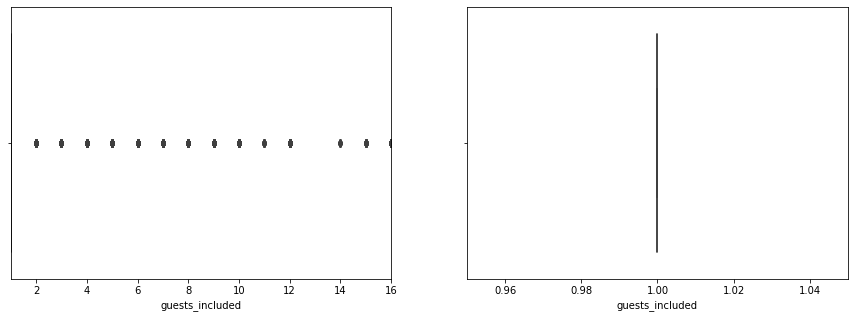

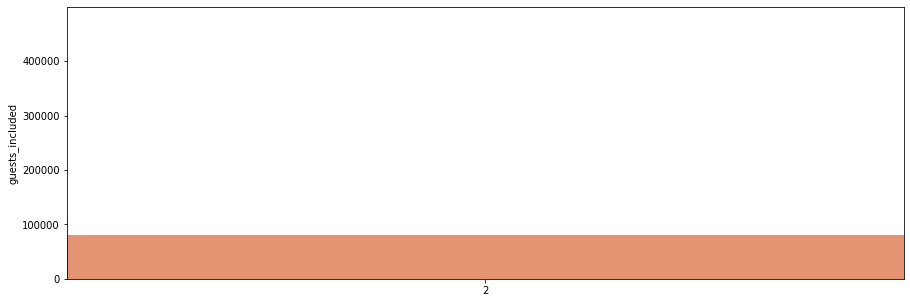

In [245]:
print(limites(base_df['guests_included']))
#diagrama_caixa(base_df['guests_included'])
#grafico_barra(base_df['guests_included'])
plt.figure(figsize=(15,5))
sns.barplot(x=base_df['guests_included'].value_counts().index, y=base_df['guests_included'].value_counts())

In [246]:
base_df = base_df.drop('guests_included', axis=1)
print(base_df.shape)

(622366, 22)


### minimum_nights

(-3.5, 8.5)


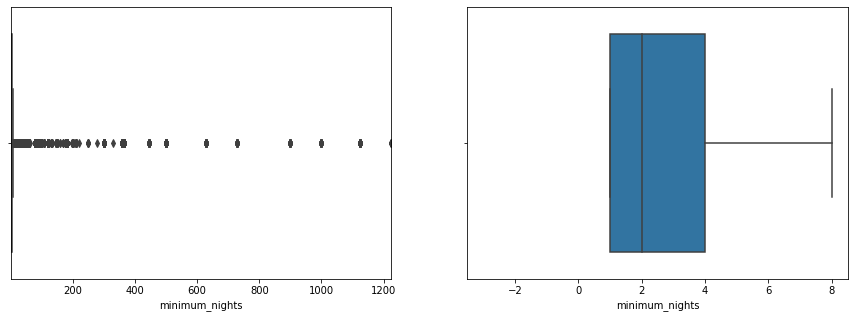

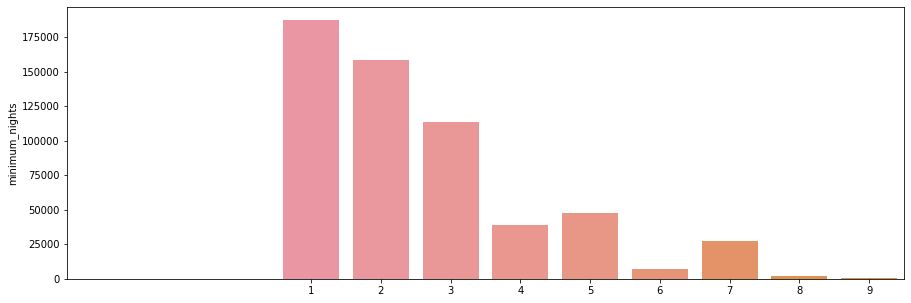

In [247]:
diagrama_caixa(base_df['minimum_nights'])
grafico_barra(base_df['minimum_nights'])

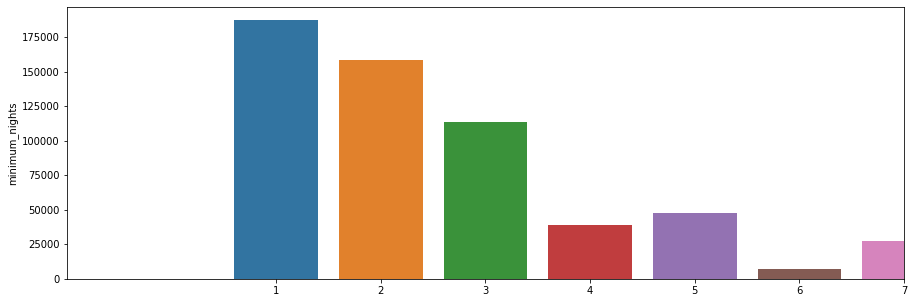

In [248]:
base_df, linhas_removidas = excluir_outliers(base_df, 'minimum_nights')
grafico_barra(base_df['minimum_nights'])

In [ ]:
print(f"Foram removidas {linhas_removidas} linhas.")

### maximum_nights

(-1612.5, 2767.5)


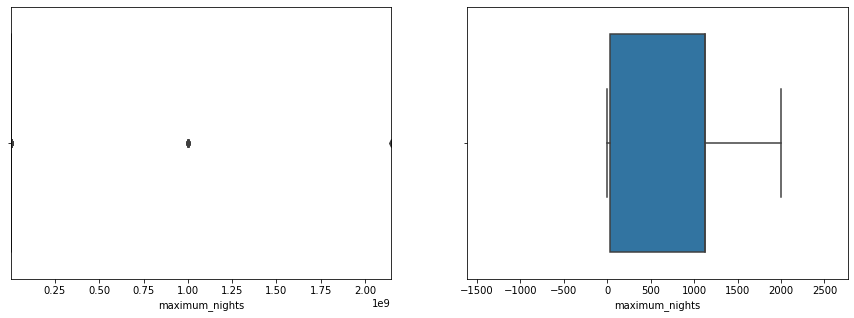

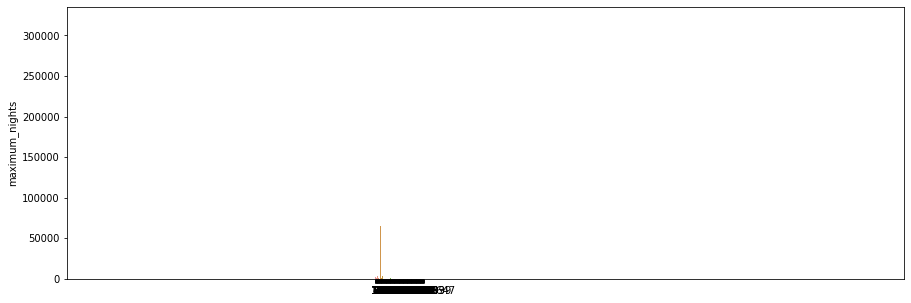

In [249]:
diagrama_caixa(base_df['maximum_nights'])
grafico_barra(base_df['maximum_nights'])

- Essa coluna não parece que vai ajudar na análise
- Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nigths, então ele não parece que vai ser um fator relevante.
- É melhor excluírmos essa coluna da análise.

In [250]:
base_df = base_df.drop('maximum_nights', axis=1)
print(base_df.shape)

(581983, 21)


             
### number_of_reviews

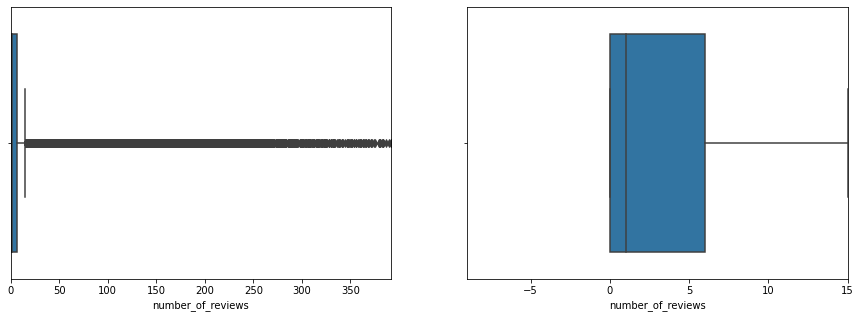

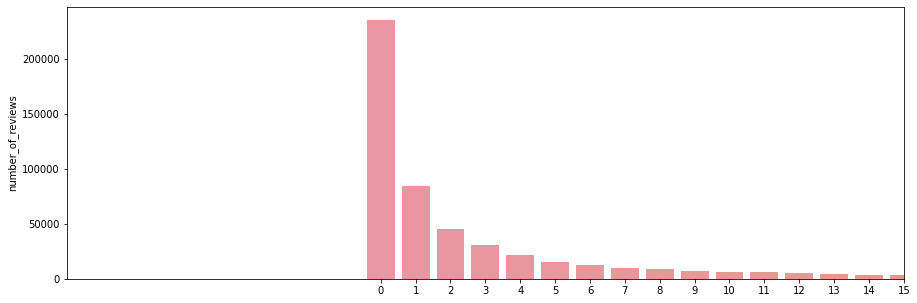

In [251]:
diagrama_caixa(base_df['number_of_reviews'])
grafico_barra(base_df['number_of_reviews'])

- Aqui poderíamos tomar algumas decisões diferentes. Eu decidi baseada na minha análise pessoal tirar essa característica do modelo, por alguns motivos:
    
    1. Se excluírmos os outliers, vamos excluir as pessoas que tem a maior quantidade de reviews( o que normalmente são os hosts que têm mais aluguel). Isso pode impactar muito negativamente o nosso modelo.
    2. Pensandoo no nosso objetivo, se eu tenho um imóvel parado e quero colocar o quero colocar lá, é claro que eu não tenho review nenhum. Então talvez tirar essa característica da análise pode na verdade ajudar.
    3. Particularmente tenho dúvida se essa característica deveria impactar ou não o preço final.

In [252]:
base_df = base_df.drop('number_of_reviews', axis=1)
print(base_df.shape)

(581983, 20)


### Tratamentos de colunas de Valores de Texto

- property_type

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


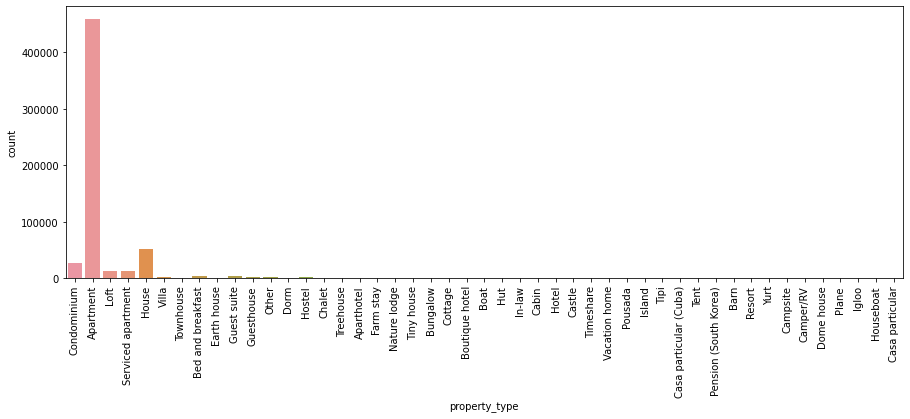

In [253]:
print(base_df['property_type'].value_counts())
plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_df)
grafico.tick_params(axis='x', rotation=90)

- Aqui a nossa ação não é "excluir outliers", mas sim agrupar valores que são muito pequenos.

- Todos os tipos de propriedade que têm menos de 2.000 propriedades na base de dados, eu vou agrupar em um grupo chamado "outros". Acho que isso vai facilitar o nosso modelo.

Apartment             458354
House                  51387
Condominium            26456
Outros                 17142
Serviced apartment     12671
Loft                   12352
Guest suite             3621
Name: property_type, dtype: int64


C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


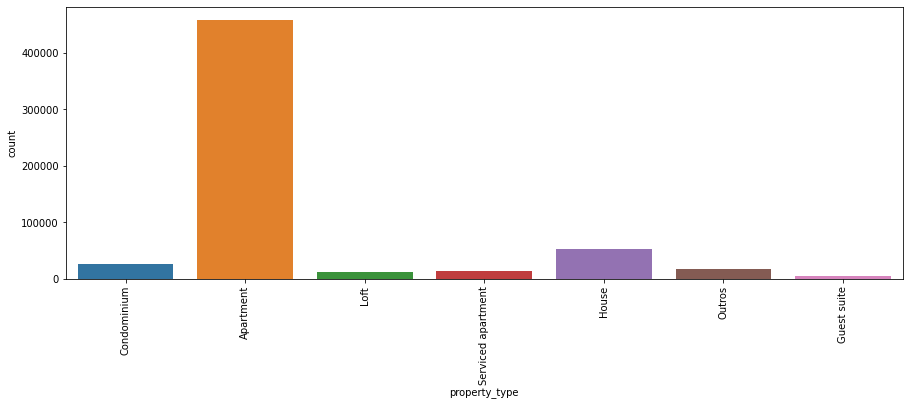

In [254]:
tabela_tipos_casa = base_df['property_type'].value_counts()
agrupar_colunas = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 3500:
        agrupar_colunas.append(tipo)

for tipo in agrupar_colunas:
    base_df.loc[base_df['property_type'] == tipo, 'property_type'] = 'Outros'
    
print(base_df['property_type'].value_counts())
plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_df)
grafico.tick_params(axis='x', rotation=90)

### room_type           


Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


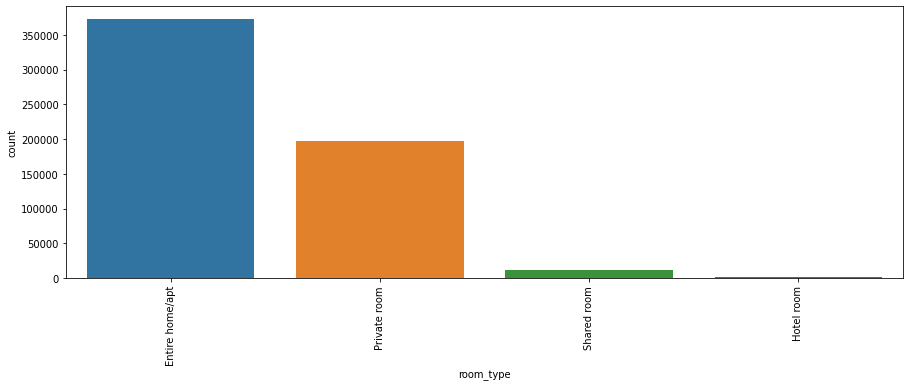

In [255]:
print(base_df['room_type'].value_counts())
plt.figure(figsize=(15,5))
grafico = sns.countplot('room_type', data=base_df)
grafico.tick_params(axis='x', rotation=90)

### bed_type            

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Real Bed    570643
Outros       11340
Name: bed_type, dtype: int64


C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


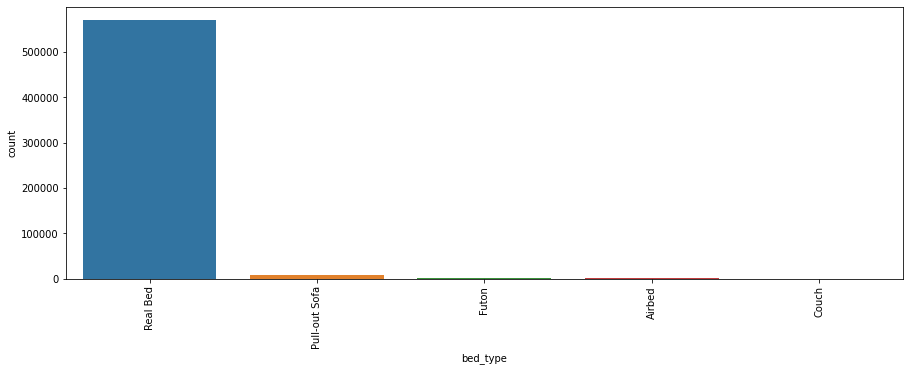

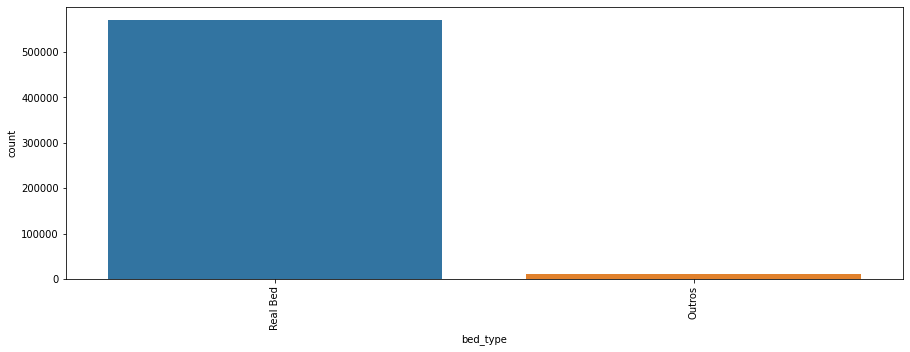

In [256]:
print(base_df['bed_type'].value_counts())
plt.figure(figsize=(15,5))
grafico = sns.countplot('bed_type', data=base_df)
grafico.tick_params(axis='x', rotation=90)

#Agrupando categorias
tabela_tipos_cama = base_df['bed_type'].value_counts()
agrupar_colunas = []

for tipo in tabela_tipos_cama.index:
    if tabela_tipos_cama[tipo] < 10000:
        agrupar_colunas.append(tipo)

for tipo in agrupar_colunas:
    base_df.loc[base_df['bed_type'] == tipo, 'bed_type'] = 'Outros'
    
print(base_df['bed_type'].value_counts())
plt.figure(figsize=(15,5))
grafico = sns.countplot('bed_type', data=base_df)
grafico.tick_params(axis='x', rotation=90)

### cancellation_policy

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
Outros                           9863
Name: cancellation_policy, dtype: int64


C:\Users\dougl\anaconda3\envs\venv_data_c\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(581983, 20)


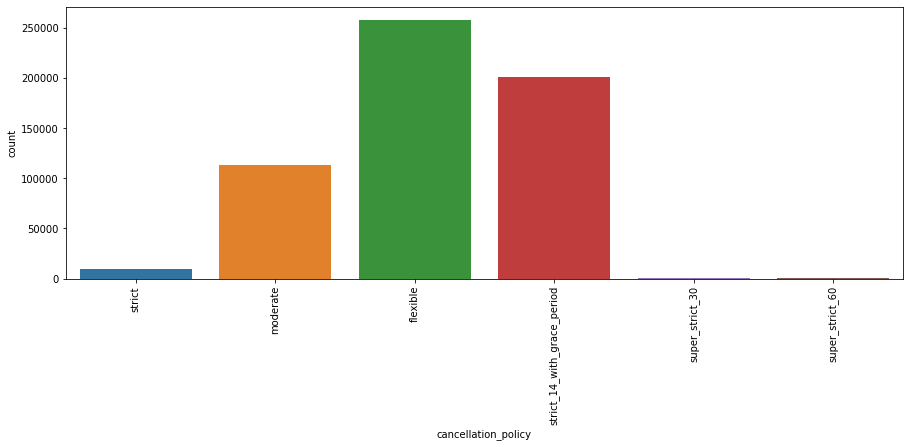

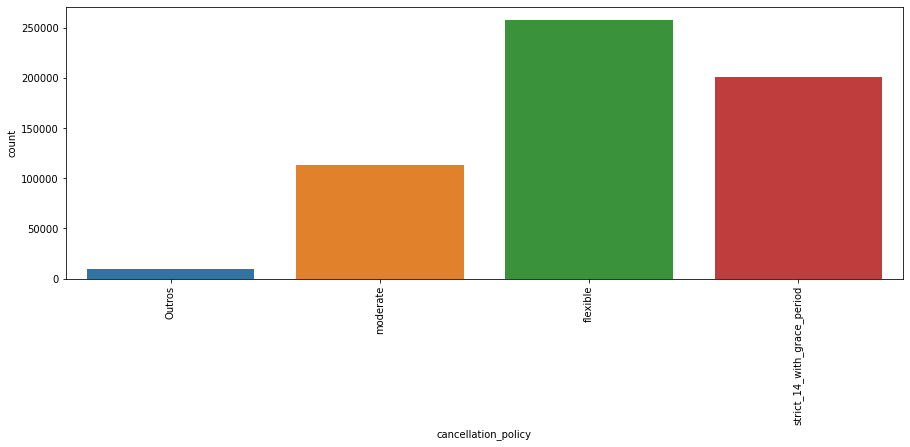

In [257]:
print(base_df['cancellation_policy'].value_counts())
plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_df)
grafico.tick_params(axis='x', rotation=90)

#Agrupando categorias
tabela_cancellation = base_df['cancellation_policy'].value_counts()
agrupar_colunas = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 17000:
        agrupar_colunas.append(tipo)

for tipo in agrupar_colunas:
    base_df.loc[base_df['cancellation_policy'] == tipo, 'cancellation_policy'] = 'Outros'
    
print(base_df['cancellation_policy'].value_counts())
plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_df)
grafico.tick_params(axis='x', rotation=90)
print(base_df.shape)

### amenities 

- Como temos uma diversidade muito grande de amenities e, às vezes as mesmas amenities podem ser escritas de forma diferentes, vamos avaliar a quantidade como o parâmetro para o nosso modelo.

In [258]:
print(base_df['amenities'].iloc[1].split(','))
print(len(base_df['amenities'].iloc[1].split(',')))

base_df['n_amenities'] = base_df['amenities'].str.split(',').apply(len)
print(base_df['n_amenities'])

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14
1        25
3        14
4        16
5        30
6        30
         ..
34323    15
34324    18
34325    12
34327    25
34328    17
Name: n_amenities, Length: 581983, dtype: int64


In [259]:
host_is_superhost            object
property_type                object
room_type                    object
bed_type                     object
amenities                    object
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object

SyntaxError: invalid syntax (Temp/ipykernel_18288/4120497272.py, line 1)